In [2]:
import os, sys
sys.path.append('../')
os.environ["PYOPENGL_PLATFORM"] = "egl"

import numpy as np
import json
import math
import rosbag
import bagpy 
from bagpy import bagreader
import torch
import cv2


import open3d as o3d
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib nbagg
%matplotlib inline

In [7]:
data = np.load('/media/qil/DATA/DITTO_Carter/Ditto/data/Shape2Motion/cabinet_test_standard/scenes/4fb76509f5914622a9d6d7c6c4b28e82.npz', allow_pickle=True)

# `data` is now a dict-like object with keys corresponding to the arrays stored in the file.
# You can list all arrays contained in the file using the `.files` attribute.
print(data.files)

['pc_start', 'pc_start_end', 'pc_seg_start', 'pc_end', 'pc_end_start', 'pc_seg_end', 'state_start', 'state_end', 'screw_axis', 'screw_moment', 'joint_type', 'joint_index', 'start_p_occ', 'start_occ_list', 'end_p_occ', 'end_occ_list', 'start_mesh_pose_dict', 'end_mesh_pose_dict', 'object_path']


In [8]:
data['start_mesh_pose_dict']

array({'0_-1': [('data/urdfs/Shape2Motion/cabinet/test/0018/part_objs/none_motion.obj', (0.1850393940214139, 0.1850393940214139, 0.1850393940214139), array([[1.        , 0.        , 0.        , 0.15      ],
       [0.        , 1.        , 0.        , 0.15      ],
       [0.        , 0.        , 1.        , 0.14993524],
       [0.        , 0.        , 0.        , 1.        ]]))], '0_0': [('data/urdfs/Shape2Motion/cabinet/test/0018/part_objs/dof_rootd_Aa001_t.obj', (0.1850393940214139, 0.1850393940214139, 0.1850393940214139), array([[1.        , 0.        , 0.        , 0.15      ],
       [0.        , 1.        , 0.        , 0.15      ],
       [0.        , 0.        , 1.        , 0.14993524],
       [0.        , 0.        , 0.        , 1.        ]]))], '0_1': [('data/urdfs/Shape2Motion/cabinet/test/0018/part_objs/dof_rootd_Aa002_t.obj', (0.1850393940214139, 0.1850393940214139, 0.1850393940214139), array([[1.        , 0.        , 0.        , 0.18919967],
       [0.        , 1.        , 0

#### Process bag files

In [39]:
bag_path = '/media/qil/DATA/DITTO_Carter/Ditto/data/bags/2024-03-25-16-26-00.bag'

# Open the .bag file
with rosbag.Bag(bag_path, 'r') as bag:
    # Get a list of all topics and their types
    topics = bag.get_type_and_topic_info()[1].keys()
    types = []
    for i, (topic, info) in enumerate(bag.get_type_and_topic_info()[1].items()):
        print(f"Topic {i}: {topic} - Message Type: {info.msg_type}")
        types.append(info.msg_type)

Topic 0: /camera/color/camera_info - Message Type: sensor_msgs/CameraInfo
Topic 1: /camera/color/image_raw - Message Type: sensor_msgs/Image
Topic 2: /camera/color/metadata - Message Type: realsense2_camera/Metadata
Topic 3: /camera/depth/camera_info - Message Type: sensor_msgs/CameraInfo
Topic 4: /camera/depth/image_rect_raw - Message Type: sensor_msgs/Image
Topic 5: /camera/depth/metadata - Message Type: realsense2_camera/Metadata
Topic 6: /camera/extrinsics/depth_to_color - Message Type: realsense2_camera/Extrinsics
Topic 7: /camera/motion_module/parameter_descriptions - Message Type: dynamic_reconfigure/ConfigDescription
Topic 8: /camera/motion_module/parameter_updates - Message Type: dynamic_reconfigure/Config
Topic 9: /camera/realsense2_camera_manager/bond - Message Type: bond/Status
Topic 10: /camera/rgb_camera/parameter_descriptions - Message Type: dynamic_reconfigure/ConfigDescription
Topic 11: /camera/rgb_camera/parameter_updates - Message Type: dynamic_reconfigure/Config
Top

In [2]:
b = bagreader('/media/qil/DATA/DITTO_Carter/Ditto/data/ROS_Data/2024-03-25-16-26-56.bag')


[INFO]  Data folder /media/qil/DATA/DITTO_Carter/Ditto/data/ROS_Data/2024-03-25-16-26-56 already exists. Not creating.


In [4]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/camera/color/camera_info,sensor_msgs/CameraInfo,1058,29.977729
1,/camera/color/image_raw,sensor_msgs/Image,1058,29.991662
2,/camera/color/metadata,realsense2_camera/Metadata,1057,22.797856
3,/camera/depth/camera_info,sensor_msgs/CameraInfo,1058,29.981586
4,/camera/depth/image_rect_raw,sensor_msgs/Image,1057,29.987052
5,/camera/depth/metadata,realsense2_camera/Metadata,1057,22.799095
6,/camera/extrinsics/depth_to_color,realsense2_camera/Extrinsics,1,NaN
7,/camera/motion_module/parameter_descriptions,dynamic_reconfigure/ConfigDescription,1,NaN
8,/camera/motion_module/parameter_updates,dynamic_reconfigure/Config,1,NaN
9,/camera/realsense2_camera_manager/bond,bond/Status,72,9.920702


In [10]:
newmsg = b.message_by_topic(topic='/camera/rgb_camera/parameter_updates')

In [11]:
newmsg

'/media/qil/DATA/DITTO_Carter/Ditto/data/ROS_Data/2024-03-25-16-26-56/camera-rgb_camera-parameter_updates.csv'

In [73]:
import pandas as pd
veldf = pd.read_csv('/media/qil/DATA/DITTO_Carter/Ditto/data/ROS_Data/2024-03-25-16-26-00/camera-depth-camera_info.csv')

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(veldf)


/tmp/ipykernel_165304/3122125438.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,height,width,distortion_model,D_0,D_1,D_2,D_3,D_4,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,P_11,binning_x,binning_y,roi.x_offset,roi.y_offset,roi.height,roi.width,roi.do_rectify
0,1.711409e+09,0,1711409161,22118330,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
1,1.711409e+09,1,1711409161,55461407,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
2,1.711409e+09,2,1711409161,88805199,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
3,1.711409e+09,3,1711409161,122148275,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
4,1.711409e+09,4,1711409161,155491829,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
5,1.711409e+09,5,1711409161,188834906,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
6,1.711409e+09,6,1711409161,222178698,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
7,1.711409e+09,7,1711409161,255521536,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
8,1.711409e+09,8,1711409161,288865328,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False
9,1.711409e+09,9,1711409161,322207928,camera_depth_optical_frame,480,848,plumb_bob,0.0,0.0,0.0,0.0,0.0,429.848389,0.0,426.878693,0.0,429.848389,239.449722,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,429.848389,0.0,426.878693,0.0,0.0,429.848389,239.449722,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,False


### What to do now?
Based on the bag file
1. Read camera depth info to grab the details of the focal lens and camera center (intrinsics)
2. Read the extrinsics to apply the camera2base transformations
3. Iterate through all images and apply camera2base transforms and convert to Point clouds using o3d

In [8]:
def plot_3d_point_cloud(x,
                        y,
                        z,
                        show=True,
                        show_axis=True,
                        in_u_sphere=False,
                        marker='.',
                        s=8,
                        alpha=.8,
                        figsize=(5, 5),
                        elev=10,
                        azim=240,
                        axis=None,
                        title=None,
                        lim=None,
                        *args,
                        **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if lim:
        ax.set_xlim3d(*lim[0])
        ax.set_ylim3d(*lim[1])
        ax.set_zlim3d(*lim[2])
    elif in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        lim = (min(np.min(x), np.min(y),
                   np.min(z)), max(np.max(x), np.max(y), np.max(z)))
        ax.set_xlim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_ylim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_zlim(1.3 * lim[0], 1.3 * lim[1])
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if show:
        plt.show()

    return fig

In [50]:
# def read_depth(depth_path):
#     depth_img = np.array(Image.open(depth_path))
#     depth_img = depth_img.astype(np.float32) * 0.001
    
    
#     rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
#         o3d.geometry.Image(np.empty_like(depth_img)),
#         o3d.geometry.Image(depth_img),
#         depth_scale=1.0,
#         depth_trunc=0.7,
#         convert_rgb_to_intensity=False,
#     )
#     return rgbd

''' 
For bag files use this function 

'''
def resize_image(image, target_width, target_height):
    return cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_AREA)

def read_depth(RGB_path, depth_path):
    depth_img = np.array(Image.open(depth_path))
    depth_img = depth_img.astype(np.float32) # * 0.001
    RGB_img = np.array(Image.open(RGB_path))
    RGB_img = RGB_img.astype(np.float32) # * 0.001
    
    RGB_img = resize_image(RGB_img, target_width=848, target_height=480)
    depth_img = resize_image(depth_img, target_width=848, target_height=480)
    
    RGB_img = (RGB_img * 255).astype(np.uint8)
    
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(RGB_img),
        o3d.geometry.Image(depth_img),
        depth_scale=1.0,
        depth_trunc=0.7,
        convert_rgb_to_intensity=True,
    )
    return rgbd


def sum_downsample_points(point_list, voxel_size=0.01, nb_neighbors=20, std_ratio=2.0):
    points = np.concatenate([np.asarray(x.points) for x in point_list], axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return pcd

In [17]:
def normalize(tensor: torch.Tensor, dim: int) -> torch.Tensor:
    return tensor / ((tensor ** 2).sum(dim, keepdim=True).sqrt() + 1.0e-5)

def vector_to_rotation(vector):
    z = np.array(vector)
    z = z / np.linalg.norm(z)
    x = np.array([1, 0, 0])
    x = x - z*(x.dot(z)/z.dot(z))
    x = x / np.linalg.norm(x)
    y = np.cross(z, x)
    return np.c_[x, y, z]

def add_r_joint_to_scene(scene,
                             axis,
                             pivot_point,
                             length,
                             radius=0.01,
                             joint_color=[200, 0, 0, 180],
                             recenter=False):
    if recenter:
        pivot_point = np.cross(axis, np.cross(pivot_point, axis))
    rotation_mat = vector_to_rotation(axis)
    screw_tran = np.eye(4)
    screw_tran[:3, :3] = rotation_mat
    screw_tran[:3, 3] = pivot_point
    
    axis_cylinder = trimesh.creation.cylinder(radius, height=length)
    axis_arrow = trimesh.creation.cone(radius * 2, radius * 4)
    arrow_trans = np.eye(4)
    arrow_trans[2, 3] = length / 2
    axis_arrow.apply_transform(arrow_trans)
    axis_obj = trimesh.Scene((axis_cylinder, axis_arrow))
    screw = as_mesh(axis_obj)
    
    # screw.apply_translation([0, 0, 0.1])
    screw.apply_transform(screw_tran)
    screw.visual.face_colors = np.array(joint_color, dtype=np.uint8)
    scene.add_geometry(screw)
    return screw

# load data

In [39]:
# # read data
# root = '../data/real_laptop'
# num_point_per_depth = 2048

# with open(os.path.join(root, 'camera2base.json')) as f:
#     transform_dict = json.load(f)

# src_img_dir = os.path.join(root, 'imgs_1')
# dst_img_dir = os.path.join(root, 'imgs_2')

# transforms = transform_dict['camera2base']
# print(np.shape(transforms))
# intrinsics = o3d.camera.PinholeCameraIntrinsic(
#     width=640,
#     height=480,
#     fx=635.647,
#     fy=635.647,
#     cx=321.300,
#     cy=241.436,
# )

# # Intrinsics of bag data 
# # intrinsics = o3d.camera.PinholeCameraIntrinsic(
# #     width=848,
# #     height=480,
# #     fx=429.848,
# #     fy=429.848389,
# #     cx=426.87869,
# #     cy=239.449722,
# # )

# # read data
# src_data = []
# for idx in range(len(transforms)):
#     rgbd = read_depth(os.path.join(src_img_dir, f'{idx}_depth.png'))
#     src_data.append((rgbd, np.array(transforms[idx])))

# dst_data = []
# for idx in range(len(transforms)):
#     rgbd = read_depth(os.path.join(dst_img_dir, f'{idx}_depth.png'))
#     dst_data.append((rgbd, np.array(transforms[idx])))

(8, 4, 4)


In [27]:
root = '../data/ROS_Data'
with open(os.path.join(root, 'camera2base.json')) as f:
    transform_dict = json.load(f)

transforms = transform_dict['camera2base']
print(np.shape(transforms))
print(transforms[0])

(1, 4, 4)
[[0.999988, 0.004511, -0.002095, -0.059303], [-0.004519, 0.999982, -0.00398, -0.000277], [0.002077, 0.003989, 0.99999, 0.000476], [0.0, 0.0, 0.0, 1.0]]


In [51]:
# read data
root = '../data/ROS_Data'
num_point_per_depth = 2048

with open(os.path.join(root, 'camera2base.json')) as f:
    transform_dict = json.load(f)

src_img_dir = os.path.join(root,  '2024-03-25-16-27-40')
dst_img_dir = os.path.join(root, '2024-03-25-16-26-56')

# num_imgs_src = len([name for name in os.listdir(src_img_dir)])
# num_imgs_dst = len([name for name in os.listdir(dst_img_dir)])

num_imgs_src = 500
num_imgs_dst = 500


transforms = transform_dict['camera2base']
print(np.shape(transforms))
print(transforms[0])


# Intrinsics of bag data 
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=848,
    height=480,
    fx=429.848,
    fy=429.848389,
    cx=426.87869,
    cy=239.449722,
)

# read data
src_data = []
for idx in range(num_imgs_src):
    rgbd = read_depth(os.path.join(dst_img_dir, 'color_images', f'{idx}_color.png') ,os.path.join(src_img_dir, 'depth_images', f'{idx}_depth.png'))
    src_data.append((rgbd, np.array(transforms[0])))

dst_data = []
for idx in range(num_imgs_dst):
    rgbd = read_depth(os.path.join(dst_img_dir, 'color_images', f'{idx}_color.png'), os.path.join(dst_img_dir, 'depth_images', f'{idx}_depth.png'))
    dst_data.append((rgbd, np.array(transforms[0])))

(1, 4, 4)
[[0.999988, 0.004511, -0.002095, -0.059303], [-0.004519, 0.999982, -0.00398, -0.000277], [0.002077, 0.003989, 0.99999, 0.000476], [0.0, 0.0, 0.0, 1.0]]


In [45]:
print(src_data[0])

(RGBDImage of size 
Color image : 848x480, with 3 channels.
Depth image : 848x480, with 1 channels.
Use numpy.asarray to access buffer data., array([[ 9.99988e-01,  4.51100e-03, -2.09500e-03, -5.93030e-02],
       [-4.51900e-03,  9.99982e-01, -3.98000e-03, -2.77000e-04],
       [ 2.07700e-03,  3.98900e-03,  9.99990e-01,  4.76000e-04],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]]))


In [60]:
# crop out the object
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(0.3, -0.5, 0.03), max_bound=(0.7, 0.16, 1))

# find bounding box of data
src_pc_list = []
for rgbd, trans in src_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    # pcd, tmp = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.01)
    pcd.transform(trans)
    # pcd = pcd.crop(bbox)
    pc = np.asarray(pcd.points)
    pc_idx = np.random.randint(0, size=(2048, ))
    pc = pc[pc_idx]
    src_pc_list.append(pc)
src_fused_pc = np.concatenate(src_pc_list, axis=0)
center = (np.min(src_fused_pc, 0) + np.max(src_fused_pc, 0)) / 2
scale = (np.max(src_fused_pc, 0) - np.min(src_fused_pc, 0)).max()
scale *= 1.1

# back project and normalize point cloud

src_pcd_list = []
for rgbd, trans in src_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    pcd.transform(trans)
    pcd = pcd.crop(bbox)
    center_transform = np.eye(4)
    center_transform[:3, 3] = -center
    pcd.transform(center_transform)
    pcd.scale(1 / scale, np.zeros((3, 1)))
    src_pcd_list.append(pcd)
    
dst_pcd_list = []
for rgbd, trans in dst_data:
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)
    # pcd, tmp = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.01)
    pcd.transform(trans)
    pcd = pcd.crop(bbox)
    center_transform = np.eye(4)
    center_transform[:3, 3] = -center
    pcd.transform(center_transform)
    pcd.scale(1 / scale, np.zeros((3, 1)))
    dst_pcd_list.append(pcd)
    
src_pcd = sum_downsample_points(src_pcd_list, 0.02, 50, 0.1)
dst_pcd = sum_downsample_points(dst_pcd_list, 0.02, 50, 0.1)

PointCloud with 0 points.
0


ValueError: high <= 0

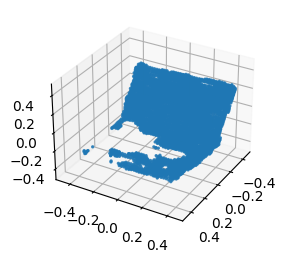

In [41]:
# visualize crop results
# tune crop box to get better isolated objects
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d_point_cloud(*np.asarray(src_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_point_cloud(*np.asarray(dst_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3)

plt.show()

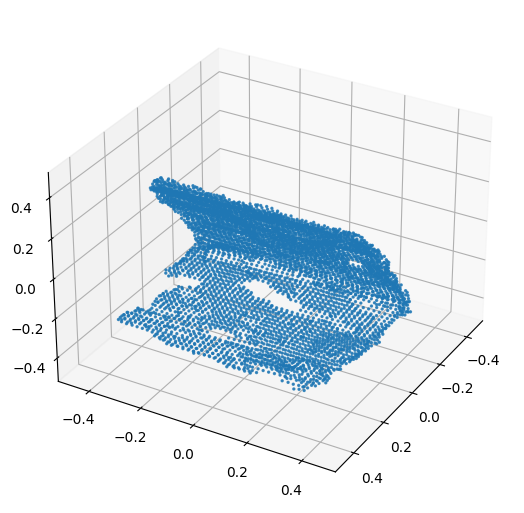

In [35]:
# Plotting
fig = plt.figure(figsize=(14, 7))

# # Subplot for source point cloud
# ax1 = fig.add_subplot(1, 2, 1, projection='3d')
# plot_3d_point_cloud(*np.asarray(src_pcd.points).T, axis=ax1, azim=30, elev=30, lim=[(-0.5, 0.5)] * 3)
# ax1.set_title('Source Point Cloud')

# Subplot for destination point cloud
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_point_cloud(*np.asarray(dst_pcd.points).T, axis=ax2, azim=30, elev=30, lim=[(-0.5, 0.5)] * 3)
ax2.set_title('Destination Point Cloud')

# Display the figure
plt.show()

1. when you read depth image, check for the min and max values of the depth
2. when you save, preserve or save the normalization values
3. when you load, you unnormalize and get the raw values
4. You want the metric depth values, 
5. keep 255 and truncate between 0 and 1. truncation can put a large number (50 etc.)

0 255


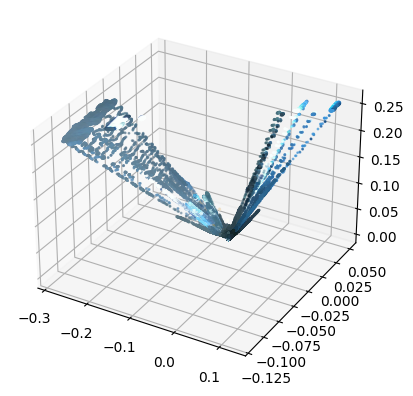

In [74]:
def read_depth(RGB_path, depth_path):
    # Load images
    depth_img = np.array(Image.open(depth_path))
    print(np.amin(depth_img), np.amax(depth_img))
    RGB_img = np.array(Image.open(RGB_path))

    # Resize images to match the depth intrinsics
    RGB_img = cv2.resize(RGB_img, (848, 480), interpolation=cv2.INTER_AREA)

    # Convert to Open3D image format
    depth_o3d = o3d.geometry.Image(depth_img.astype(np.float32))
    RGB_o3d = o3d.geometry.Image(RGB_img.astype(np.uint8))

    # Create RGBD image from color and depth
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        RGB_o3d, depth_o3d, depth_scale=255, depth_trunc=3.0, convert_rgb_to_intensity=False)
    return rgbd

def transform_point_cloud(pcd, transform):
    pcd.transform(transform)
    return pcd

def load_transformations(file_path):
    with open(file_path, 'r') as f:
        transform_dict = json.load(f)
    return np.array(transform_dict['camera2base'][0])

# Intrinsics of the depth camera
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=848, height=480, fx=429.848, fy=429.848, cx=426.87869, cy=239.449722)

# Load the camera to base transformation matrix
camera2base_transform = load_transformations('../data/ROS_Data/camera2base.json')

# Directories
src_img_dir = '../data/ROS_Data/2024-03-25-16-27-40'
dst_img_dir = '../data/ROS_Data/2024-03-25-16-26-56'

# Processing the data
rgbd_image = read_depth(os.path.join(src_img_dir, 'color_images', '0_color.png'), os.path.join(src_img_dir, 'depth_images', '0_depth.png'))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
pcd = transform_point_cloud(pcd, camera2base_transform)

# Optionally, visualize the point cloud
# o3d.visualization.draw_geometries([pcd])

# Extract points for plotting
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)  # Assuming there are colors associated with the points

# Plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
plt.show()

# Run model

In [9]:
import torch
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import hydra

from src.third_party.ConvONets.conv_onet.generation_two_stage import Generator3D
from src.utils.misc import sample_point_cloud

In [10]:
with initialize(config_path='../configs/'):
    config = compose(
        config_name='config',
        overrides=[
            'experiment=Ditto_s2m.yaml',
        ], return_hydra_config=True)
config.datamodule.opt.train.data_dir = '../data/'
config.datamodule.opt.val.data_dir = '../data/'
config.datamodule.opt.test.data_dir = '../data/'

/media/qil/DATA/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/media/qil/DATA/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/media/qil/DATA/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)
/media/qil/DATA/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for m

In [11]:
model = hydra.utils.instantiate(config.model)
ckpt = torch.load('../data/Ditto_s2m.ckpt')
device = torch.device(0)
model.load_state_dict(ckpt['state_dict'], strict=True)
model = model.eval().to(device)

In [12]:
generator = Generator3D(
    model.model,
    device=device,
    threshold=0.4,
    seg_threshold=0.5,
    input_type='pointcloud',
    refinement_step=0,
    padding=0.1,
    resolution0=32
)

In [13]:
pc_start = np.asarray(src_pcd.points)
pc_end = np.asarray(dst_pcd.points)

bound_max = np.maximum(pc_start.max(0), pc_end.max(0))
bound_min = np.minimum(pc_start.min(0), pc_end.min(0))
norm_center = (bound_max + bound_min) / 2
norm_scale = (bound_max - bound_min).max() * 1.1
pc_start = (pc_start - norm_center) / norm_scale
pc_end = (pc_end - norm_center) / norm_scale

pc_start, _ = sample_point_cloud(pc_start, 8192)
pc_end, _ = sample_point_cloud(pc_end, 8192)
sample = {
    'pc_start': torch.from_numpy(pc_start).unsqueeze(0).to(device).float(),
    'pc_end': torch.from_numpy(pc_end).unsqueeze(0).to(device).float()
}

In [14]:
mesh_dict, mobile_points_all, c, stats_dict = generator.generate_mesh(sample)
with torch.no_grad():
    joint_type_logits, joint_param_revolute, joint_param_prismatic = model.model.decode_joints(mobile_points_all, c)

# Visualize results

In [15]:
import trimesh
from src.utils.joint_estimation import aggregate_dense_prediction_r

from utils3d.mesh.utils import as_mesh
from utils3d.render.pyrender import get_pose, PyRenderer

In [16]:
renderer = PyRenderer(light_kwargs={'color': np.array([1., 1., 1.]), 'intensity': 9})

In [17]:
# compute articulation model
mesh_dict[1].visual.face_colors = np.array([84, 220, 83, 255], dtype=np.uint8)
joint_type_prob = joint_type_logits.sigmoid().mean()

if joint_type_prob.item()< 0.5:
    # axis voting
    joint_r_axis = (
        normalize(joint_param_revolute[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_r_t = joint_param_revolute[:, :, 3][0].cpu().numpy()
    joint_r_p2l_vec = (
        normalize(joint_param_revolute[:, :, 4:7], -1)[0].cpu().numpy()
    )
    joint_r_p2l_dist = joint_param_revolute[:, :, 7][0].cpu().numpy()
    p_seg = mobile_points_all[0].cpu().numpy()

    pivot_point = p_seg + joint_r_p2l_vec * joint_r_p2l_dist[:, np.newaxis]
    (
        joint_axis_pred,
        pivot_point_pred,
        config_pred,
    ) = aggregate_dense_prediction_r(
        joint_r_axis, pivot_point, joint_r_t, method="mean"
    )
# prismatic
else:
    # axis voting
    joint_p_axis = (
        normalize(joint_param_prismatic[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_axis_pred = joint_p_axis.mean(0)
    joint_p_t = joint_param_prismatic[:, :, 3][0].cpu().numpy()
    config_pred = joint_p_t.mean()
    
    pivot_point_pred = mesh_dict[1].bounds.mean(0)

In [18]:
scene = trimesh.Scene()
static_part = mesh_dict[0].copy()
mobile_part = mesh_dict[1].copy()
scene.add_geometry(static_part)
scene.add_geometry(mobile_part)
add_r_joint_to_scene(scene, joint_axis_pred, pivot_point_pred, 1.0, recenter=True)

<trimesh.Trimesh(vertices.shape=(100, 3), faces.shape=(192, 3))>

In [19]:
# render result mesh
camera_pose = get_pose(1.5, ax=np.pi / 3, ay=0, az=np.pi/2)
light_pose = get_pose(1.5, ax=np.pi / 3, ay=0, az=np.pi/2)
rgb, depth = renderer.render_mesh(scene, camera_pose, light_pose)

(480, 640, 3)


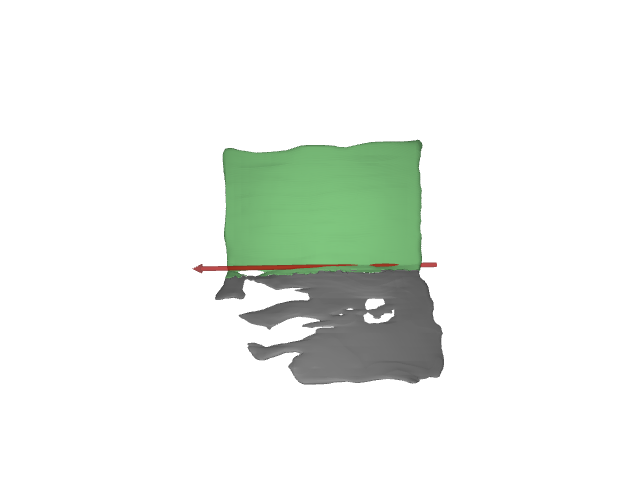

In [31]:
print(np.shape(rgb))
Image.fromarray(rgb)